In [ ]:
#default_exp core.utils

In [ ]:
#export
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#hide
from vase.config import DATA_PATH
from vase.core.models import PaperVanillaVAE, FCVAE
from vase.core.datasets.moving_mnist import MovingFashionMNIST, CommonMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import os

In [ ]:
#hide
batch_size = 128
latents = 8

In [ ]:
#hide
mnist_data = CommonMNIST(DATA_PATH, transform=ToTensor(), download=True)
fc_vae_helper = FCVAE(latents)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
mnist_batch, mnnist_labels = iter(mnist_loader).next()
rec, mu, logvar = fc_vae_helper(mnist_batch)

# Utility Functions

## Reconstruction Likelihood
We'll use Binary Cross Entropy Loss with $y$ the ground truth image $x$, and $p(y)$ the reconstructed image. In terms of log likelihood, I'm not really sure how this makes sense, but it seems to be how its done... (TODO figure this out)

In [ ]:
#export
def rec_likelihood(x, x_rec):
    """Returns element wise reconstruction loss across batch"""
    return F.binary_cross_entropy(x_rec, x, reduction='none').flatten(start_dim=1).sum(dim=1)

In [ ]:
assert rec_likelihood(mnist_batch, rec).shape == torch.Size([batch_size])

## KL Divergence Std Norm
Recall the definition of KL Divergence is the expected value under the reference distribution of the information ratio (or something like that):

$$D_{KL}(q||p) = E_q[\log{\frac{q}{p}}] $$

So in our case, with
$$KL(q_{\phi}(\mathbf{z}|\mathbf{x})||p(z))$$
we have 

$$KL(q_{\phi}(\mathbf{z}|\mathbf{x})||p(z)) = E_{q_{\phi}(\mathbf{z}|x)}[\log{q_{\phi}(\mathbf{z}|\mathbf{x})} - \log{p(z)}]$$

Note that both $q_{\phi}(\mathbf{z}|x))$ and $p(z)$ are diagonal gaussians. The KL divergence between diagonal gaussians can be [derived analytically](https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes), and is given by:

$$  \frac{1}{2} \left[-(\sum_{i}{\log{\sigma_i^2} + 1}) + \sum_{i}(\sigma_i^2) + \sum_{i}{\mu_i^{2}} \right]$$

TODO: see Kigma 2014 for real derivation - this one is off (or Kigma's is off, idk...)

In [ ]:
#export
def kl_div_stdnorm(mu, logvar):
    """Returns element wise KL Divergence across batch"""
    return .5 * torch.sum(-(1 + logvar) + logvar.exp() + mu.pow(2), dim=1)#torch.mean(0.5 * (logvar.exp() + mu.pow(2) - 1) - logvar) #NOTE: this might be off, other implementations scale logvar too #-.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) #

In [ ]:
assert kl_div_stdnorm(mu, logvar).shape == torch.Size([batch_size])

In [ ]:
#assert kl_div_stdnorm(torch.Tensor([0]), torch.log(torch.Tensor([1]))) == 0

Let $\mu_1$ = 2, $\sigma_1^2$ = 4, then we would have
$$KL(q, p) = \log \frac{1}{4} + \frac{4 + (2-0)^2}{2} - \frac{1}{2} = 4 - \frac{1}{2} + log{\frac{1}{4}}

In [ ]:
#assert kl_div_stdnorm(torch.Tensor([2]), torch.log(torch.Tensor([4]))) == 4 - .5 + torch.log(torch.Tensor([.25]))

## Euclidean Distance 
(batch-wise)

In [ ]:
#export
def euclidean(x_1, x_2):
    return (x_1-x_2).pow(2).sum(1).sqrt()

In [ ]:
x = torch.zeros((64, 8))
y = torch.ones((64, 8))

In [ ]:
assert euclidean(x, y).shape == torch.Size([64])
assert euclidean(x, y)[0] == torch.tensor(8).sqrt()

## Show Batch

In [ ]:
#export
def show(imgs):
    """
    Plots list of images
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
#export
def show_batch(batch: torch.Tensor):
    """
    Shows 4D batch of tensors
    """
    grid = torchvision.utils.make_grid(batch)
    show(grid)

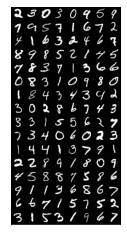

In [ ]:
show_batch(mnist_batch)

## Disable Gradients

### Explore

In [ ]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)
    
    def forward(self, x):
        x = x.reshape(-1, 784)
        return self.linear(x)

In [ ]:
lin_model = LinearModel()
criterion = nn.CrossEntropyLoss()

In [ ]:
out = lin_model(mnist_batch)

In [ ]:
loss = criterion(out, mnnist_labels)

In [ ]:
loss.backward()

In [ ]:
lin_model = LinearModel()
criterion = nn.CrossEntropyLoss()

In [ ]:
for layer in lin_model.children():
    layer.requires_grad_(False)

In [ ]:
out = lin_model(mnist_batch)
loss = criterion(out, mnnist_labels)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
try:
    loss.backward()
    assert False
except RuntimeError:
    pass


### Function Def

In [ ]:
#export 
def disable_gradient(model: nn.Module):
    for layer in model.children():
        layer.requires_grad_(False)

In [ ]:
linear_model = LinearModel()
disable_gradient(linear_model)
out = linear_model(mnist_batch)
loss = criterion(out, mnnist_labels)

In [ ]:
try:
    loss.backward()
    assert False
except RuntimeError:
    pass